In [1]:
import pandas as pd 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

## Data Preparation

In [2]:
data = pd.read_csv("combined_stocks.csv")
data.reset_index()

,index,Date,Close,Volume,OpenInt,EGS,Company_Name,day,year,month,...,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,Tomorrow_Close
0,0,3/1/1980,0.26459,12665490,0,2,INTC,3,1980,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26459
1,1,4/1/1980,0.26459,13431648,0,2,INTC,4,1980,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26459
2,2,7/1/1980,0.26459,11564146,0,2,INTC,0,1980,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28077
3,3,8/1/1980,0.28077,15586456,0,2,INTC,1,1980,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28868
4,4,9/1/1980,0.28868,19656654,0,2,INTC,2,1980,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168242,168242,10/11/2017,111.12000,2161752,0,1,SWKS,4,2017,11,...,106.800,106.870,107.190,104.640,106.430,106.170,106.93,105.570,105.360,110.41000
168243,168243,10/11/2017,52.33000,1023885,0,0,TEAM,4,2017,11,...,33.820,33.800,35.030,34.370,34.460,34.390,34.90,34.900,35.600,52.40000
168244,168244,10/11/2017,97.05000,4239733,0,1,TXN,4,2017,11,...,82.174,82.363,81.697,80.863,81.469,81.548,81.33,82.015,82.293,96.94000
168245,168245,10/11/2017,109.42000,497915,0,1,VRSN,4,2017,11,...,103.320,103.730,104.650,103.310,103.480,102.790,102.54,103.940,103.750,109.75000


In [3]:
data.columns

Index(['Date', 'Close', 'Volume', 'OpenInt', 'EGS', 'Company_Name', 'day',
       'year', 'month', 'h-c', 'c-l', 'c-o', 'ewm10', 'ewm50', 'ewm100',
       'ewm200', 'ma10', 'ma50', 'ma100', 'ma200', 'std10', 'std50', 'std100',
       'std200', 'UB', 'LB', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7',
       'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15',
       'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23',
       'lag24', 'lag25', 'lag26', 'lag27', 'lag28', 'lag29', 'lag30', 'lag31',
       'lag32', 'lag33', 'lag34', 'lag35', 'lag36', 'lag37', 'lag38', 'lag39',
       'lag40', 'lag41', 'lag42', 'lag43', 'lag44', 'lag45', 'lag46', 'lag47',
       'lag48', 'lag49', 'lag50', 'Tomorrow_Close'],
      dtype='object')

In [4]:
len(data)

168247

In [5]:
data = data.dropna()

In [6]:
len(data)

161330

In [7]:
data.head()

,Date,Close,Volume,OpenInt,EGS,Company_Name,day,year,month,h-c,...,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,Tomorrow_Close
199,15/10/1980,0.40097,8296020,0,2,INTC,2,1980,10,0.00817,...,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285,0.35285,0.40914
200,16/10/1980,0.40914,5506736,0,2,INTC,3,1980,10,0.00793,...,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285,0.40914
201,17/10/1980,0.40914,7410151,0,2,INTC,4,1980,10,0.00793,...,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.40914
202,20/10/1980,0.40914,8715007,0,2,INTC,0,1980,10,0.00000,...,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.40097
203,21/10/1980,0.40097,8092510,0,2,INTC,1,1980,10,0.00000,...,0.36881,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.39291


In [8]:
data = data.reset_index()

In [9]:
X = data.loc[:, "Close":"lag50"]

Text(0.5, 1.0, 'Plot of standard deviations of stock prices against time')

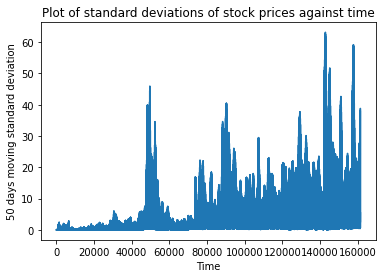

In [10]:
plt.plot(X["std50"])
plt.xlabel("Time")
plt.ylabel("50 days moving standard deviation")
plt.title("Plot of standard deviations of stock prices against time")

In [11]:
X = X.drop("Company_Name", axis = 1)

In [12]:
X.head()

,Close,Volume,OpenInt,EGS,day,year,month,h-c,c-l,c-o,...,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50
0,0.40097,8296020,0,2,2,1980,10,0.00817,0.0,0.0,...,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285,0.35285
1,0.40914,5506736,0,2,3,1980,10,0.00793,0.0,0.0,...,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285
2,0.40914,7410151,0,2,4,1980,10,0.00793,0.0,0.0,...,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091
3,0.40914,8715007,0,2,0,1980,10,0.00000,0.0,0.0,...,0.36881,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091
4,0.40097,8092510,0,2,1,1980,10,0.00000,0.0,0.0,...,0.36881,0.36881,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489


In [13]:
egs = ["zero", "one", "two"]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
for i in range(len(X)):
  X['month'][i] = months[X['month'][i]-1]
  X['day'][i] = days[X['day'][i]]
  X['EGS'][i]= egs[X['EGS'][i]]

/var/folders/n5/gkbdqwls1h17gjm6d68_h8ph0000gn/T/ipykernel_88612/3095439742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'][i] = months[X['month'][i]-1]
/Users/zhangaijia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/n5/gkbdqwls1h17gjm6d68_h8ph0000gn/T/ipykernel_88612/3095439742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [14]:
X.head()

,Close,Volume,OpenInt,EGS,day,year,month,h-c,c-l,c-o,...,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50
0,0.40097,8296020,0,two,Wed,1980,Oct,0.00817,0.0,0.0,...,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285,0.35285
1,0.40914,5506736,0,two,Thu,1980,Oct,0.00793,0.0,0.0,...,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091,0.35285
2,0.40914,7410151,0,two,Fri,1980,Oct,0.00793,0.0,0.0,...,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091,0.36091
3,0.40914,8715007,0,two,Mon,1980,Oct,0.00000,0.0,0.0,...,0.36881,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489,0.36091
4,0.40097,8092510,0,two,Tue,1980,Oct,0.00000,0.0,0.0,...,0.36881,0.36881,0.36881,0.36091,0.36091,0.37681,0.37681,0.37681,0.38489,0.38489


In [15]:
X = pd.get_dummies(data=X, drop_first=False)

In [16]:
X.head()

,Close,Volume,OpenInt,year,h-c,c-l,c-o,ewm10,ewm50,ewm100,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0.40097,8296020,0,1980,0.00817,0.0,0.0,0.395752,0.372162,0.348589,...,0,0,0,0,0,0,0,0,1,0
1,0.40914,5506736,0,1980,0.00793,0.0,0.0,0.398186,0.373612,0.349810,...,0,0,0,0,0,0,0,0,1,0
2,0.40914,7410151,0,1980,0.00793,0.0,0.0,0.400178,0.375006,0.351006,...,0,0,0,0,0,0,0,0,1,0
3,0.40914,8715007,0,1980,0.00000,0.0,0.0,0.401807,0.376345,0.352177,...,0,0,0,0,0,0,0,0,1,0
4,0.40097,8092510,0,1980,0.00000,0.0,0.0,0.401655,0.377311,0.353160,...,0,0,0,0,0,0,0,0,1,0


In [17]:
X.drop('month_Jan', axis=1, inplace=True)
X.drop("day_Mon", axis=1, inplace=True)
X.drop("EGS_zero", axis = 1, inplace=True)
X.drop("OpenInt", axis = 1, inplace=True)

In [18]:
X.head()

,Close,Volume,year,h-c,c-l,c-o,ewm10,ewm50,ewm100,ewm200,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0.40097,8296020,1980,0.00817,0.0,0.0,0.395752,0.372162,0.348589,0.327908,...,0,0,0,0,0,0,0,0,1,0
1,0.40914,5506736,1980,0.00793,0.0,0.0,0.398186,0.373612,0.349810,0.328841,...,0,0,0,0,0,0,0,0,1,0
2,0.40914,7410151,1980,0.00793,0.0,0.0,0.400178,0.375006,0.351006,0.329762,...,0,0,0,0,0,0,0,0,1,0
3,0.40914,8715007,1980,0.00000,0.0,0.0,0.401807,0.376345,0.352177,0.330672,...,0,0,0,0,0,0,0,0,1,0
4,0.40097,8092510,1980,0.00000,0.0,0.0,0.401655,0.377311,0.353160,0.331476,...,0,0,0,0,0,0,0,0,1,0


In [19]:
Y = data["Tomorrow_Close"]

In [20]:
X_test = X.tail(30000)
Y_test = Y.tail(30000)

In [21]:
X_test

,Close,Volume,year,h-c,c-l,c-o,ewm10,ewm50,ewm100,ewm200,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
131330,81.190,382287,2014,0.752,0.490,-0.260,82.600160,82.833075,83.257915,81.987836,...,0,0,0,0,0,1,0,0,0,0
131331,59.763,2494793,2014,0.117,2.582,1.333,58.851388,54.132910,49.919022,44.720392,...,0,0,0,0,0,1,0,0,0,0
131332,174.180,4052786,2014,1.270,4.920,2.420,175.621760,169.917644,163.563615,149.881461,...,0,0,0,0,0,1,0,0,0,0
131333,15.520,2540762,2014,0.080,0.165,-0.010,15.531756,14.705522,14.329646,14.059103,...,0,0,0,0,0,1,0,0,0,0
131334,51.360,4430526,2014,0.438,1.074,-0.379,52.020034,49.865588,47.616333,44.114624,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161325,111.120,2161752,2017,1.480,1.590,-0.590,111.356977,106.983353,104.741142,99.776384,...,0,0,0,0,0,0,0,1,0,0
161326,52.330,1023885,2017,0.130,1.050,0.050,50.402332,42.837982,39.463636,36.153968,...,0,0,0,0,0,0,0,1,0,0
161327,97.050,4239733,2017,0.980,1.420,-0.550,97.153276,91.313149,87.082707,82.025967,...,0,0,0,0,0,0,0,1,0,0
161328,109.420,497915,2017,0.200,0.960,-0.040,109.108105,106.525932,102.705838,96.958312,...,0,0,0,0,0,0,0,1,0,0


In [22]:
X_train = X[:131330]
Y_train = Y[:131330]

In [23]:
X_train

,Close,Volume,year,h-c,c-l,c-o,ewm10,ewm50,ewm100,ewm200,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0.40097,8296020,1980,0.00817,0.000,0.000,0.395752,0.372162,0.348589,0.327908,...,0,0,0,0,0,0,0,0,1,0
1,0.40914,5506736,1980,0.00793,0.000,0.000,0.398186,0.373612,0.349810,0.328841,...,0,0,0,0,0,0,0,0,1,0
2,0.40914,7410151,1980,0.00793,0.000,0.000,0.400178,0.375006,0.351006,0.329762,...,0,0,0,0,0,0,0,0,1,0
3,0.40914,8715007,1980,0.00000,0.000,0.000,0.401807,0.376345,0.352177,0.330672,...,0,0,0,0,0,0,0,0,1,0
4,0.40097,8092510,1980,0.00000,0.000,0.000,0.401655,0.377311,0.353160,0.331476,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131325,68.06000,2433603,2014,0.04000,1.310,1.000,68.122016,64.106186,60.287052,54.950559,...,0,0,0,0,0,1,0,0,0,0
131326,47.15900,1635168,2014,0.00000,0.549,0.500,46.818284,45.555591,44.780004,43.371396,...,0,0,0,0,0,1,0,0,0,0
131327,52.34000,1982479,2014,0.27000,0.710,-0.250,53.104171,51.706788,48.835162,44.983838,...,0,0,0,0,0,1,0,0,0,0
131328,18.40200,10802911,2014,0.01000,0.554,0.387,18.112920,17.149781,16.587655,15.638892,...,0,0,0,0,0,1,0,0,0,0


In [24]:
#tscv = TimeSeriesSplit(n_splits = 5)
tscv = TimeSeriesSplit(n_splits = 3, max_train_size=30000)


In [25]:
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    print(len(train_index), len(test_index))

TRAIN: [ 2834  2835  2836 ... 32831 32832 32833] TEST: [32834 32835 32836 ... 65663 65664 65665]
30000 32832
TRAIN: [35666 35667 35668 ... 65663 65664 65665] TEST: [65666 65667 65668 ... 98495 98496 98497]
30000 32832
TRAIN: [68498 68499 68500 ... 98495 98496 98497] TEST: [ 98498  98499  98500 ... 131327 131328 131329]
30000 32832


In [26]:
Y_train = np.array(Y_train).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


## Linear Regression

In [27]:
lr = LinearRegression()

In [28]:
cv_results = cross_val_score(lr, X_train, Y_train, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [29]:
cv_results

array([-1.34817509, -1.13677545, -1.30697967])

In [30]:
cv_results.mean()

-1.2639767380482865

In [31]:
lr.fit(X_train, Y_train)
Y_test_pred = lr.predict(X_test)
Y_train_pred = lr.predict(X_train)

In [32]:
print(sklearn.metrics.mean_squared_error(Y_train, Y_train_pred))
print(sklearn.metrics.mean_squared_error(Y_test, Y_test_pred))

1.1235780560956559
7.456050270495296


## Feature selection

### removing highly correlated columns

In [33]:
cor_matrix = X_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


/var/folders/n5/gkbdqwls1h17gjm6d68_h8ph0000gn/T/ipykernel_88612/285798651.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [34]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)


['ewm10', 'ewm50', 'ewm100', 'ewm200', 'ma10', 'ma50', 'ma100', 'ma200', 'UB', 'LB', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24', 'lag25', 'lag26', 'lag27', 'lag28', 'lag29', 'lag30', 'lag31', 'lag32', 'lag33', 'lag34', 'lag35', 'lag36', 'lag37', 'lag38', 'lag39', 'lag40', 'lag41', 'lag42', 'lag43', 'lag44', 'lag45', 'lag46', 'lag47', 'lag48', 'lag49', 'lag50']


In [35]:
X_train_v1 = pd.DataFrame()
for column in X_train.columns:
    if column not in to_drop:
        X_train_v1[column] = X_train[column]



In [36]:
X_train_v1.head()

,Close,Volume,year,h-c,c-l,c-o,std10,std50,std100,std200,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0.40097,8296020,1980,0.00817,0.0,0.0,0.012150,0.014639,0.045390,0.047705,...,0,0,0,0,0,0,0,0,1,0
1,0.40914,5506736,1980,0.00793,0.0,0.0,0.010634,0.014879,0.045470,0.048177,...,0,0,0,0,0,0,0,0,1,0
2,0.40914,7410151,1980,0.00793,0.0,0.0,0.007439,0.015029,0.045509,0.048633,...,0,0,0,0,0,0,0,0,1,0
3,0.40914,8715007,1980,0.00000,0.0,0.0,0.004306,0.015349,0.045625,0.049075,...,0,0,0,0,0,0,0,0,1,0
4,0.40097,8092510,1980,0.00000,0.0,0.0,0.004219,0.015347,0.045591,0.049480,...,0,0,0,0,0,0,0,0,1,0


In [37]:
X_test_v1 = pd.DataFrame()
for column in X_test.columns:
    if column not in to_drop:
        X_test_v1[column] = X_test[column]

### Scaling

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [43]:
X_train_v1.columns

Index(['Close', 'Volume', 'year', 'h-c', 'c-l', 'c-o', 'std10', 'std50',
       'std100', 'std200', 'EGS_one', 'EGS_two', 'day_Fri', 'day_Thu',
       'day_Tue', 'day_Wed', 'month_Apr', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep'],
      dtype='object')

In [44]:
X_train_cont = X_train_v1.loc[:, :"std200"]
X_test_cont = X_test_v1.loc[:, :"std200"]

In [45]:
X_train_discrete = X_train_v1.loc[:,'EGS_one':'month_Sep']
X_test_discrete = X_test_v1.loc[:,'EGS_one':'month_Sep']

In [46]:
scaler.fit(X_train_cont)
X_train_cont_scaled = pd.DataFrame(scaler.transform(X_train_cont))
X_test_cont_scaled = pd.DataFrame(scaler.transform(X_test_cont))

In [47]:
X_train_cont_scaled

,0,1,2,3,4,5,6,7,8,9
0,-0.570437,-0.337498,-2.718544,-0.455498,-0.479176,0.003352,-0.552212,-0.562786,-0.556743,-0.589938
1,-0.570233,-0.400513,-2.718544,-0.455795,-0.479176,0.003352,-0.553439,-0.562695,-0.556721,-0.589845
2,-0.570233,-0.357511,-2.718544,-0.455795,-0.479176,0.003352,-0.556028,-0.562638,-0.556711,-0.589756
3,-0.570233,-0.328032,-2.718544,-0.465602,-0.479176,0.003352,-0.558566,-0.562517,-0.556680,-0.589669
4,-0.570437,-0.342096,-2.718544,-0.465602,-0.479176,0.003352,-0.558636,-0.562517,-0.556689,-0.589589
...,...,...,...,...,...,...,...,...,...,...
131325,1.120509,-0.469940,1.480192,-0.416133,1.151038,1.115971,-0.005035,1.022276,0.746449,0.859685
131326,0.598148,-0.487978,1.480192,-0.465602,0.204020,0.559662,-0.244950,-0.116341,-0.248284,-0.242822
131327,0.727632,-0.480132,1.480192,-0.131684,0.404375,-0.274803,0.080347,0.124173,0.692414,0.719452
131328,-0.120552,-0.280863,1.480192,-0.453235,0.210242,0.433936,-0.332030,-0.223519,-0.363706,-0.367125


In [48]:
X_test_discrete = X_test_discrete.reset_index()

In [49]:
X_test_discrete = X_test_discrete.drop("index", axis = 1)

In [50]:
X_train_scaled = pd.concat([X_train_cont_scaled, X_train_discrete], axis = 1)
X_test_scaled = pd.concat([X_test_cont_scaled, X_test_discrete], axis = 1)

In [51]:
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,-0.570437,-0.337498,-2.718544,-0.455498,-0.479176,0.003352,-0.552212,-0.562786,-0.556743,-0.589938,...,0,0,0,0,0,0,0,0,1,0
1,-0.570233,-0.400513,-2.718544,-0.455795,-0.479176,0.003352,-0.553439,-0.562695,-0.556721,-0.589845,...,0,0,0,0,0,0,0,0,1,0
2,-0.570233,-0.357511,-2.718544,-0.455795,-0.479176,0.003352,-0.556028,-0.562638,-0.556711,-0.589756,...,0,0,0,0,0,0,0,0,1,0
3,-0.570233,-0.328032,-2.718544,-0.465602,-0.479176,0.003352,-0.558566,-0.562517,-0.556680,-0.589669,...,0,0,0,0,0,0,0,0,1,0
4,-0.570437,-0.342096,-2.718544,-0.465602,-0.479176,0.003352,-0.558636,-0.562517,-0.556689,-0.589589,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131325,1.120509,-0.469940,1.480192,-0.416133,1.151038,1.115971,-0.005035,1.022276,0.746449,0.859685,...,0,0,0,0,0,1,0,0,0,0
131326,0.598148,-0.487978,1.480192,-0.465602,0.204020,0.559662,-0.244950,-0.116341,-0.248284,-0.242822,...,0,0,0,0,0,1,0,0,0,0
131327,0.727632,-0.480132,1.480192,-0.131684,0.404375,-0.274803,0.080347,0.124173,0.692414,0.719452,...,0,0,0,0,0,1,0,0,0,0
131328,-0.120552,-0.280863,1.480192,-0.453235,0.210242,0.433936,-0.332030,-0.223519,-0.363706,-0.367125,...,0,0,0,0,0,1,0,0,0,0


In [52]:
col_names = ['Close', 'Volume', 'year', 'h-c', 'c-l', 'c-o', 'std10', 'std50',
       'std100', 'std200', 'EGS_one', 'EGS_two', 'day_Fri', 'day_Thu',
       'day_Tue', 'day_Wed', 'month_Apr', 'month_Aug', 'month_Dec',
       'month_Feb', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       'month_Nov', 'month_Oct', 'month_Sep']

In [53]:
X_train_scaled.columns = col_names
X_test_scaled.columns = col_names

In [54]:
X_test_scaled

,Close,Volume,year,h-c,c-l,c-o,std10,std50,std100,std200,...,month_Aug,month_Dec,month_Feb,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1.448657,-0.516283,1.480192,0.464421,0.130598,-0.285929,0.094937,0.408643,0.142394,0.338796,...,0,0,0,0,0,1,0,0,0,0
1,0.913149,-0.468558,1.480192,-0.320905,2.733963,1.486474,0.044519,0.698630,1.037634,0.936449,...,0,0,0,0,0,1,0,0,0,0
2,3.772680,-0.433360,1.480192,1.105049,5.643460,2.695891,3.456732,2.507122,1.725706,4.821896,...,0,0,0,0,0,1,0,0,0,0
3,-0.192580,-0.467519,1.480192,-0.366664,-0.273844,-0.007774,-0.366429,-0.336467,-0.341316,-0.439368,...,0,0,0,0,0,1,0,0,0,0
4,0.703140,-0.424826,1.480192,0.076087,0.857350,-0.418331,0.072899,0.050484,0.135199,0.702923,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2.196673,-0.476082,1.850668,1.364763,1.499481,-0.653094,1.309430,0.841110,0.464997,0.424089,...,0,0,0,0,0,0,0,1,0,0
29996,0.727382,-0.501788,1.850668,-0.304827,0.827484,0.058983,1.114808,1.871280,0.809524,0.449986,...,0,0,0,0,0,0,0,1,0,0
29997,1.845033,-0.429137,1.850668,0.746396,1.287926,-0.608589,0.192947,1.564670,1.214666,0.579344,...,0,0,0,0,0,0,0,1,0,0
29998,2.154186,-0.513671,1.850668,-0.218256,0.715484,-0.041153,0.122558,0.323272,0.805822,1.128250,...,0,0,0,0,0,0,0,1,0,0


### Linear Regression

In [101]:
lr2 = LinearRegression()
cv_results_2 = cross_val_score(lr2, X_train_scaled, Y_train, cv = tscv, scoring = 'neg_root_mean_squared_error')
cv_results_2.mean()

-1.24689008717122

In [102]:
lr2.fit(X_train_scaled, Y_train)
Y_test_pred_2 = lr2.predict(X_test_scaled)
Y_train_pred_2 = lr2.predict(X_train_scaled)
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_pred_2)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_pred_2)))

1.069643725585062
2.7163750706597836


In [103]:
lr2.coef_

array([[ 4.00541477e+01,  6.60073825e-04,  2.23080550e-03,
         8.93738964e-02, -1.05325752e-01,  1.05496344e-01,
         4.64701757e-02, -2.47469929e-02, -3.89847860e-03,
        -2.72151328e-02,  1.09366930e-02, -4.49143904e-03,
         2.29345131e-02,  4.95431772e-02,  3.94299105e-02,
         3.13975186e-02,  1.84751507e-02,  4.05797050e-03,
         3.11774699e-02,  2.09828422e-02,  3.13096848e-03,
        -1.00211203e-02,  1.32189060e-02, -1.22952095e-02,
         9.75469356e-03,  3.19506199e-02, -1.21580389e-02]])

### Lasso

In [55]:
lasso = Lasso()


In [56]:
param_grid = {'alpha': np.linspace(0, 10, 100)}

In [57]:
from sklearn.model_selection import GridSearchCV

lasso_cv = GridSearchCV(lasso, param_grid, cv=tscv, scoring = 'neg_root_mean_squared_error')

In [58]:
lasso_cv.fit(X_train_scaled, Y_train)

/Users/zhangaijia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/zhangaijia/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/zhangaijia/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.746e+02, tolerance: 5.700e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=30000, n_splits=3, test_size=None),
             estimator=Lasso(),
             param_grid={'alpha': array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,...
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ])},
             scoring='neg_root_mean_squared_error')

In [59]:
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'alpha': 0.0}
-1.2468900871712196


### Ridge

In [60]:
ridge = Ridge()

In [61]:
ridge_cv = GridSearchCV(ridge, param_grid, cv=tscv, scoring = 'neg_root_mean_squared_error')

In [62]:
ridge_cv.fit(X_train_scaled, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=30000, n_splits=3, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,...
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ])},
             scoring='neg_root_mean_squared_error')

In [63]:
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'alpha': 0.10101010101010101}
-1.246889968234491


In [64]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, Y_train)
Y_train_ridge_pred = ridge.predict(X_train_scaled)
Y_test_ridge_pred = ridge.predict(X_test_scaled)

print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_ridge_pred)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_ridge_pred)))


1.1441377027373592
7.378705699994064


#### Feature Importance

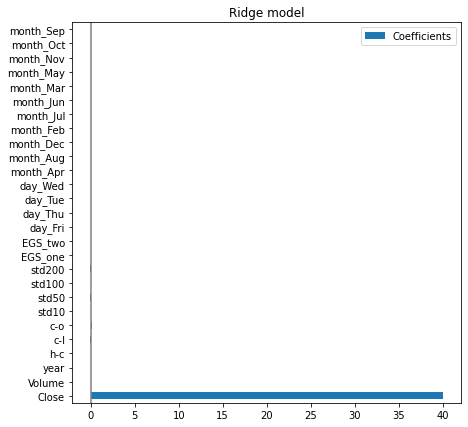

In [78]:
coefs = pd.DataFrame(
   ridge.coef_.T,
   columns=['Coefficients'], 
   index=X_train_scaled.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [100]:
ridge.coef_

array([[ 4.00540476e+01,  6.58404160e-04,  2.24739998e-03,
         8.93692124e-02, -1.05326908e-01,  1.05496873e-01,
         4.64816936e-02, -2.47211937e-02, -3.88554886e-03,
        -2.71802430e-02,  1.09440556e-02, -4.48435273e-03,
         2.29340023e-02,  4.95426664e-02,  3.94289674e-02,
         3.13967446e-02,  1.84731757e-02,  4.05940844e-03,
         3.11758943e-02,  2.09807614e-02,  3.13229499e-03,
        -1.00214110e-02,  1.32155395e-02, -1.22964854e-02,
         9.75275456e-03,  3.19501311e-02, -1.21552191e-02]])

In [113]:
ridge.intercept_

array([23.19871557])

In [105]:
LinearRegression().fit(np.array(X_train_scaled["Close"]).reshape(-1,1), np.array(X_train["Close"]).reshape(-1,1)).coef_

array([[40.01251361]])

In [111]:
LinearRegression().fit(np.array(X_train_scaled["Close"]).reshape(-1,1), np.array(X_train["Close"]).reshape(-1,1)).intercept_

array([23.22560493])

### RFE

In [79]:
from sklearn.feature_selection import RFECV
linreg_rfe = LinearRegression()
rfecv = RFECV(estimator=linreg_rfe, cv=tscv, scoring='neg_root_mean_squared_error')
rfecv.fit(X_train_scaled, Y_train)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=30000, n_splits=3, test_size=None),
      estimator=LinearRegression(), scoring='neg_root_mean_squared_error')

In [80]:
rfecv.cv_results_

{'mean_test_score': array([-1.22948988, -1.23046708, -1.24155472, -1.24242193, -1.24243588,
        -1.24792486, -1.24796275, -1.24813428, -1.24856877, -1.24855488,
        -1.24960976, -1.24753256, -1.24662252, -1.24723774, -1.24710951,
        -1.24729322, -1.24709798, -1.24708439, -1.24698271, -1.24688797,
        -1.24692992, -1.2468588 , -1.24684562, -1.24686973, -1.24688638,
        -1.24689083, -1.24689009]),
 'std_test_score': array([0.11048797, 0.10870779, 0.09051144, 0.09095181, 0.09100701,
        0.08397424, 0.0840816 , 0.08358232, 0.08297942, 0.08320322,
        0.08341051, 0.08641897, 0.08763162, 0.08670061, 0.08672523,
        0.0862077 , 0.08593023, 0.08582504, 0.08585528, 0.08630684,
        0.08631371, 0.08627283, 0.0862855 , 0.08624747, 0.0862268 ,
        0.08623242, 0.08623342]),
 'split0_test_score': array([-1.33970974, -1.33860034, -1.33692549, -1.3379347 , -1.33824558,
        -1.33871779, -1.33889794, -1.33864527, -1.33865356, -1.33859129,
        -1.33857303, 

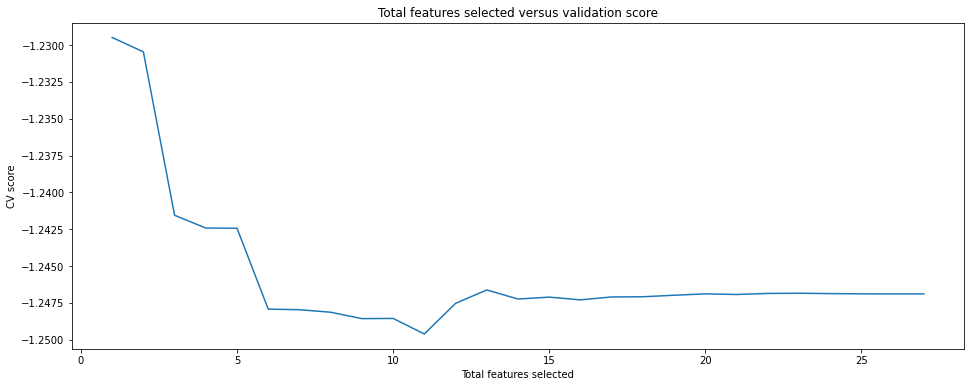

In [81]:
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus validation score')
plt.xlabel('Total features selected')
plt.ylabel('CV score')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [82]:
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(X_train_v1.shape[1]):
    row = {'feature': i, 'support': rfecv.support_[i], 'ranking': rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
    
df_features.sort_values(by='ranking').head(10)

,feature,support,ranking
0,0,True,1
4,4,False,2
5,5,False,3
3,3,False,4
6,6,False,5
9,9,False,6
25,25,False,7
18,18,False,8
7,7,False,9
13,13,False,10


In [83]:
df_features[df_features['support']==True]


,feature,support,ranking
0,0,True,1


In [84]:
X_train_rfe = rfecv.transform(X_train_scaled)
X_test_rfe = rfecv.transform(X_test_scaled)

In [85]:
X_train_rfe

array([[-0.57043742],
       [-0.57023323],
       [-0.57023323],
       ...,
       [ 0.72763224],
       [-0.12055241],
       [-0.4827391 ]])

In [86]:
X_train_rfe.shape[1]

1

In [87]:
cv_results_rfe = cross_val_score(linreg_rfe, X_train_rfe, Y_train, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [88]:
cv_results_rfe.mean()

-1.2294898817498414

In [89]:
linreg_rfe.fit(X_train_rfe, Y_train)

LinearRegression()

In [90]:
Y_train_rfe_pred = linreg_rfe.predict(X_train_rfe)
Y_test_rfe_pred = linreg_rfe.predict(X_test_rfe)

In [114]:
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_rfe_pred)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_rfe_pred)))

1.0717534954800483
2.720829014330574


#### RFE + Ridge

In [265]:
ridge_rfe = Ridge()
ridge_rfe_cv = GridSearchCV(ridge_rfe, param_grid, cv=tscv, scoring = 'neg_root_mean_squared_error')
ridge_rfe_cv.fit(X_train_rfe, Y_train)
print(ridge_rfe_cv.best_params_)
print(ridge_rfe_cv.best_score_)

{'alpha': 0.10101010101010101}
-1.2294870044604844


In [117]:
ridge_rfe = Ridge(alpha = 0.1)
ridge_rfe.fit(X_train_rfe, Y_train)
Y_train_ridge_rfe_pred = ridge_rfe.predict(X_train_rfe)
Y_test_ridge_rfe_pred = ridge_rfe.predict(X_test_rfe)
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_ridge_rfe_pred)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_ridge_rfe_pred)))

1.0717534959135477
2.720831317607202


In [98]:
ridge_rfe.coef_


array([[40.03322627]])

In [116]:
ridge_rfe.intercept_

array([23.23850162])

### Principle component regression

In [273]:
import sklearn.model_selection
from sklearn.decomposition import PCA


In [274]:
pca = PCA()


In [275]:
pca.fit(X_train_scaled)
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [276]:
X_train_reduced.shape

(131330, 27)

In [277]:
lr_pca = LinearRegression()

In [306]:
mse = []
for i in np.arange(1, 27):
    score = -1*sklearn.model_selection.cross_val_score(lr_pca,
               X_train_reduced[:,:i], Y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
    mse.append(score)

Text(0.5, 1.0, 'hp')

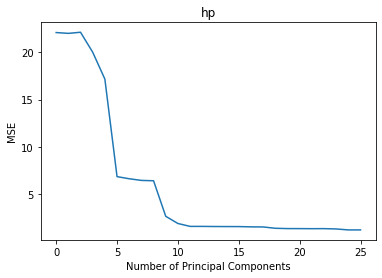

In [307]:
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

In [308]:
pd.DataFrame(X_train_reduced)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-1.810134,-0.128979,0.240644,-2.460070,-0.324731,0.312487,-0.512902,-0.688663,-0.014101,0.186144,...,0.284515,-0.664966,-0.330223,0.029648,-0.021146,-0.029795,-0.075789,-0.023430,-0.102350,-0.018486
1,-1.807630,-0.128102,0.186137,-2.473127,-0.315414,0.347206,-0.156171,0.489954,-0.684419,0.009027,...,0.278075,-0.671747,-0.329075,0.010490,-0.036712,-0.041988,-0.083201,-0.023543,-0.105056,-0.019002
2,-1.810168,-0.124957,0.225954,-2.463548,-0.309923,0.341987,-0.172874,0.431416,0.723238,-0.103510,...,0.285253,-0.666040,-0.331199,0.025794,-0.021473,-0.010479,-0.072493,-0.022705,-0.105471,-0.018963
3,-1.815926,-0.124900,0.248964,-2.457186,-0.330219,0.324699,-0.013974,0.016155,0.016198,0.118703,...,0.289019,-0.658526,-0.340260,0.017908,-0.043017,-0.018652,-0.089092,-0.028266,0.395150,-0.014547
4,-1.815588,-0.128753,0.223298,-2.463025,-0.343978,0.304035,0.782935,-0.168653,0.040009,0.398100,...,0.284891,-0.662746,-0.328506,0.029706,-0.021052,-0.032107,-0.075867,-0.022589,-0.102295,-0.018298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131325,1.904071,1.665754,-0.621695,1.139873,-0.468750,-0.330138,-0.241613,0.588967,-0.670541,0.267923,...,0.041644,0.160959,0.007798,0.099838,-0.028524,0.031548,-0.011956,-0.126637,-0.106245,-0.020852
131326,0.059223,0.816353,-0.904837,1.370102,-0.249958,0.298528,-0.213157,0.534690,-0.696176,0.004523,...,0.127236,-0.024834,-0.066102,0.073861,-0.036595,0.002479,-0.002784,0.094295,-0.104282,-0.025739
131327,1.240891,0.122984,-0.712189,1.256172,-0.301224,-0.248023,-0.195210,0.542208,-0.685014,0.101519,...,0.084943,0.167374,-0.001393,0.047790,-0.036895,-0.079443,-0.054120,0.196970,-0.111272,-0.035891
131328,-0.431446,0.686156,-0.617663,1.428060,0.289086,-0.085350,-0.154148,0.493123,-0.699928,-0.031624,...,0.062293,0.155796,0.005590,0.083800,-0.032473,-0.002721,-0.006142,0.036950,-0.105257,-0.025373


In [309]:
mse

[22.067158963429296,
 21.981287048623614,
 22.100250200403767,
 19.995829980581487,
 17.16087339631356,
 6.868627291703841,
 6.644039567171127,
 6.469476688476948,
 6.4320575249162255,
 2.6841609390539287,
 1.9248447130152098,
 1.6186234692756092,
 1.6186462832923263,
 1.606165442817676,
 1.600167246228512,
 1.5984196039930312,
 1.569439938118963,
 1.5608507608711777,
 1.4200254369420942,
 1.3872324688022968,
 1.3847736442420928,
 1.3762218789949274,
 1.3823150283609216,
 1.3471427015725326,
 1.247093613925829,
 1.2469791205139231]

In [310]:
train_error = []
test_error = []

for i in range(1, 27):

    X_trained_reduced_temp = pd.DataFrame(X_train_reduced).iloc[:, :i]
    X_test_reduced_temp = pd.DataFrame(X_test_reduced).iloc[:, :i]

    lr_reduced_temp = LinearRegression()
    lr_reduced_temp.fit(X_trained_reduced_temp, Y_train)

    Y_train_temp_pred = lr_reduced_temp.predict(X_trained_reduced_temp)
    Y_test_temp_pred = lr_reduced_temp.predict(X_test_reduced_temp)

    train_error.append(sklearn.metrics.mean_squared_error(Y_train, Y_train_temp_pred))
    test_error.append(sklearn.metrics.mean_squared_error(Y_test, Y_test_temp_pred))

In [311]:
len(mse)

26

In [312]:
import plotly.graph_objects as go

seq = list(range(20,27))

fig = go.Figure()
fig.add_trace(go.Scatter(x=seq, y=train_error[19:27],
                    mode='lines+markers',
                    name='train error'))
fig.add_trace(go.Scatter(x=seq, y=test_error[19:27],
                    mode='lines+markers',
                    name='test error'))
fig.add_trace(go.Scatter(x=seq, y=mse[19:27],
                    mode='lines+markers',
                    name='test error'))                    

In [313]:
lr_pca.fit(X_train_reduced, Y_train)
Y_train_reduced_pred = lr_pca.predict(X_train_reduced)
Y_test_reduced_pred = lr_pca.predict(X_test_reduced)
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_reduced_pred)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_reduced_pred)))

1.1441376996834907
7.378693524501949


#### PCA + Ridge

In [314]:
ridge_pca = Ridge()
ridge_pca_cv = GridSearchCV(ridge_pca, param_grid, cv=tscv, scoring = 'neg_root_mean_squared_error')
ridge_pca_cv.fit(X_train_reduced, Y_train)
print(ridge_pca_cv.best_params_)
print(ridge_pca_cv.best_score_)

{'alpha': 0.10101010101010101}
-1.246889968234474


In [315]:
ridge_pca.alpha = 0.1
ridge_pca.fit(X_train_reduced, Y_train)
y_train_reduced_pred = ridge_pca.predict(X_train_reduced)
y_test_reduced_pred = ridge_pca.predict(X_test_reduced)

print(np.sqrt(sklearn.metrics.mean_squared_error(y_train_reduced_pred, Y_train)))
print(np.sqrt(sklearn.metrics.mean_squared_error(y_test_reduced_pred, Y_test)))

1.1441377027373592
7.378705699994078


#### PCA + RFE

In [316]:
linreg_pca_rfe = LinearRegression()
pca_rfecv = RFECV(estimator=linreg_pca_rfe, cv=tscv, scoring='neg_root_mean_squared_error')
pca_rfecv.fit(X_train_reduced, Y_train)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=30000, n_splits=3, test_size=None),
      estimator=LinearRegression(), scoring='neg_root_mean_squared_error')

In [317]:
pca_rfecv.cv_results_["mean_test_score"]

array([-34.41009587, -31.08189946,  -9.64295665,  -6.53199815,
        -6.34581257,  -6.01729235,  -5.75420813,  -5.63992336,
        -5.48552831,  -3.81105362,  -2.83797186,  -1.68320857,
        -1.47851139,  -1.3883705 ,  -1.3783248 ,  -1.36543379,
        -1.29591548,  -1.26060397,  -1.25682116,  -1.25509825,
        -1.25773223,  -1.25021439,  -1.24859753,  -1.24628046,
        -1.24708534,  -1.24669209,  -1.24689009])

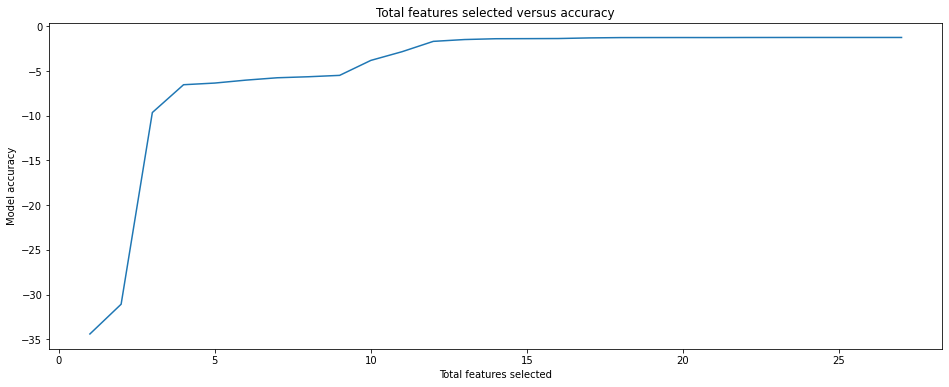

In [318]:
plt.figure( figsize=(16, 6))
plt.title('Total features selected versus accuracy')
plt.xlabel('Total features selected')
plt.ylabel('Model accuracy')
plt.plot(range(1, len(pca_rfecv.cv_results_['mean_test_score']) + 1), pca_rfecv.cv_results_['mean_test_score'])
plt.show()

In [319]:
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(X_train_reduced.shape[1]):
    row = {'feature': i, 'support': pca_rfecv.support_[i], 'ranking': pca_rfecv.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
    
df_features.sort_values(by='ranking').head(10)

,feature,support,ranking
0,0,True,1
24,24,True,1
23,23,True,1
21,21,True,1
20,20,True,1
19,19,True,1
18,18,True,1
17,17,True,1
16,16,True,1
15,15,True,1


In [320]:
df_features[df_features['support']==True]


,feature,support,ranking
0,0,True,1
1,1,True,1
2,2,True,1
3,3,True,1
4,4,True,1
5,5,True,1
6,6,True,1
7,7,True,1
8,8,True,1
9,9,True,1


In [321]:
pca_rfecv.n_features_

24

In [335]:
pca_rfecv.cv_results_

{'mean_test_score': array([-34.41009587, -31.08189946,  -9.64295665,  -6.53199815,
         -6.34581257,  -6.01729235,  -5.75420813,  -5.63992336,
         -5.48552831,  -3.81105362,  -2.83797186,  -1.68320857,
         -1.47851139,  -1.3883705 ,  -1.3783248 ,  -1.36543379,
         -1.29591548,  -1.26060397,  -1.25682116,  -1.25509825,
         -1.25773223,  -1.25021439,  -1.24859753,  -1.24628046,
         -1.24708534,  -1.24669209,  -1.24689009]),
 'std_test_score': array([16.78474571, 14.38121336,  1.67874912,  1.24383094,  1.20340816,
         1.08946451,  0.96686357,  0.92526581,  0.84153426,  0.92717601,
         0.40167114,  0.33179108,  0.14573575,  0.15593939,  0.1638046 ,
         0.17573268,  0.11608919,  0.08732184,  0.08493015,  0.08612625,
         0.09326938,  0.09133589,  0.09024266,  0.08676404,  0.08624567,
         0.08610483,  0.08623342]),
 'split0_test_score': array([-11.26943325, -10.85544802,  -9.44670818,  -7.9258303 ,
         -7.65922821,  -7.21042385,  -6.7

In [322]:
X_train_pca_rfe = pca_rfecv.transform(X_train_reduced)

X_test_pca_rfe = pca_rfecv.transform(X_test_reduced)


In [337]:
cv_results_pca_ridge = cross_val_score(linreg_pca_rfe, X_train_pca_rfe, Y_train, cv = tscv,  scoring = 'neg_root_mean_squared_error')

In [338]:
cv_results_pca_ridge.mean()

-1.246223566363251

In [323]:
linreg_pca_rfe.fit(X_train_pca_rfe, Y_train)
Y_train_pca_rfe_pred = linreg_pca_rfe.predict(X_train_pca_rfe)
Y_test_pca_rfe_pred = linreg_pca_rfe.predict(X_test_pca_rfe)
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train, Y_train_pca_rfe_pred)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test, Y_test_pca_rfe_pred)))

1.1445986371926526
7.380508199980403


In [324]:
pca_ridge_rfe = Ridge()
pca_ridge_rfe_cv = GridSearchCV(pca_ridge_rfe, param_grid, cv=tscv, scoring = 'neg_root_mean_squared_error')
pca_ridge_rfe_cv.fit(X_train_pca_rfe, Y_train)
print(pca_ridge_rfe_cv.best_params_)
print(pca_ridge_rfe_cv.best_score_)

{'alpha': 0.0}
-1.2462235663632348


## Decision tree


In [325]:
from sklearn.tree import DecisionTreeRegressor

In [326]:
tree = DecisionTreeRegressor()

In [327]:
tree.fit(X_train, Y_train)

DecisionTreeRegressor()

In [328]:
Y_train_pred_tree = tree.predict(X_train)
Y_test_pred_tree = tree.predict(X_test)

print(np.sqrt(sklearn.metrics.mean_squared_error(Y_train_pred_tree, Y_train)))
print(np.sqrt(sklearn.metrics.mean_squared_error(Y_test_pred_tree, Y_test)))

6.633188399034756e-35
1932.8475315358028


In [329]:
pd.DataFrame(Y_train_pred_tree).describe()

,0
count,131330.000000
mean,23.238502
std,40.047753
min,0.103790
25%,5.651300
50%,15.818000
75%,27.365000
max,610.080000


In [330]:
pd.DataFrame(Y_test_pred_tree).describe()

,0
count,30000.000000
mean,98.070808
std,127.661061
min,1.520000
25%,39.073000
50%,63.580000
75%,95.140000
max,610.080000


In [118]:
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from lineartree import LinearForestRegressor
from sklearn.linear_model import Ridge

In [119]:
tree = LinearTreeRegressor(base_estimator=LinearRegression())
#tree_cv = GridSearchCV(tree)

In [120]:
tree.fit(X_train_v1, Y_train)
y_pred_tree_train = tree.predict(X_train_v1)
y_pred_tree_test = tree.predict(X_test_v1)

1.1430781647163588
7.5629437100827595


In [123]:
print(np.sqrt(sklearn.metrics.mean_squared_error(y_pred_tree_train, Y_train)))
print(np.sqrt(sklearn.metrics.mean_squared_error(y_pred_tree_test, Y_test)))

1.069148336161245
2.7500806733771936


In [121]:
tree.max_depth

5

In [122]:
tree1 = LinearTreeRegressor(base_estimator=LinearRegression(), max_depth = 3)
tree1.fit(X_train_v1, Y_train)
y_pred_tree_train1 = tree1.predict(X_train_v1)
y_pred_tree_test1 = tree1.predict(X_test_v1)


1.1430781647163588
7.5629437100827595


In [124]:
print(np.sqrt(sklearn.metrics.mean_squared_error(y_pred_tree_train1, Y_train)))
print(np.sqrt(sklearn.metrics.mean_squared_error(y_pred_tree_test1, Y_test)))

1.069148336161245
2.7500806733771936
